In [1]:
import os
from dotenv import load_dotenv
import io

import h5py
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from IPython.display import clear_output

from numcodecs import GZip, Zstd, Blosc

# from albk.data.utils import get_google_maps_static_image

load_dotenv()


True

In [2]:
import requests


# First written by @dhruvpatel44
def get_google_maps_static_image(
    api_key, lat_lon: str, zoom=17, scale=1, size=(224, 244), format="png8", maptype="satellite"
):
    """Get a static image from Google Maps API.

    Args:
        api_key: API key for Google Maps API. See https://developers.google.com/maps/documentation/maps-static/get-api-key. You may first need to enable "Google Maps Static API" in your Google Cloud Console.
        lat_lon: format "lat,lon"
        zoom: Zoom level passed to Google Maps API.
        scale: Scale passed to Google Maps API. If scale=2, the image will have 2x pixels for the same area.
        size: Size of the image in pixels in (rows, columns) format.
        format: Format of the image. See https://developers.google.com/maps/documentation/maps-static/start#ImageFormats
        maptype: Type of map. See https://developers.google.com/maps/documentation/maps-static/start#MapTypes

    Raises:
        ValueError: If response code is not 200 or if image is not found.

    Returns:
        Image bytes.
    """
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": lat_lon,
        "zoom": zoom,
        "size": f"{size[0]}x{size[1]}",
        "maptype": maptype,
        "key": api_key,
        "scale": scale,
        "format": format,
    }
    response = requests.get(base_url, params=params)
    img = response.content
    code = response.status_code
    if code != 200:
        raise ValueError("Request failed with code: " + str(code) + " and message: " + str(img))
    if len(img) < 1000:
        raise ValueError("Image not found. Message: " + str(img))
    return img


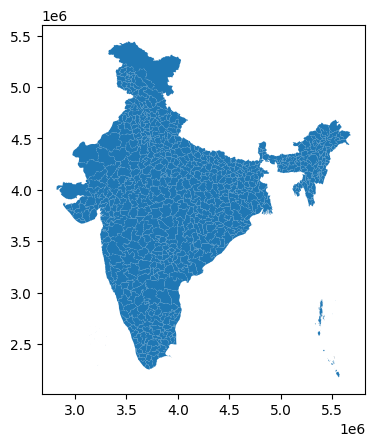

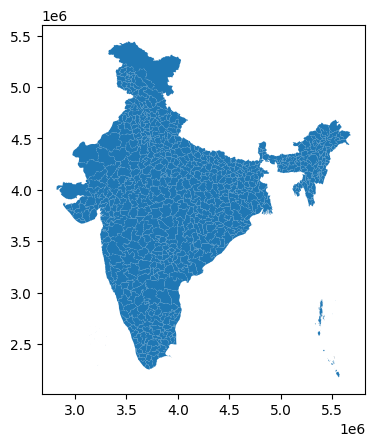

In [4]:
geometry = 'statewise'
gdf = gpd.read_file(f'shapefiles/{geometry}/DISTRICT_BOUNDARY.shp')
# gdf.head()
gdf.plot();
gdf['District'] = gdf['District'].str.replace('>', 'A')
gdf['STATE'] = gdf['STATE'].str.replace('>', 'A')
# gdf.head()
delhi_dgf = gdf[gdf['STATE'] == 'DELHI']
west_bengal_gdf = gdf[gdf['STATE'] != 'WaST BENGAL']
# odihsa_gdf = gdf[gdf['STATE'] == 'ODISHA']
# up_dgf = gdf[gdf['STATE'] == 'UTTAR PRADE
# bihar_dgf = gdf[gdf['STATE'] == 'BIHAR']
# delhi_dgf.plot();
west_bengal_gdf.plot();
# odihsa_gdf.plot();
# up_dgf.plot();
# bihar_dgf.plot();

In [5]:
west_bengal_gdf = west_bengal_gdf.to_crs(epsg=4326) 
west_bengal_gdf.head()
# delhi_dgf = delhi_dgf.to_crs(epsg=4326)
# delhi_dgf.head()

District    STATE REMARKS  State_LGD DISTRICT_L     Shape_Leng  \
0            MORBI  GUJARAT    None         24        673  539476.764723   
1        AHMADABAD  GUJARAT    None         24        438  857254.094647   
2            ANAND  GUJARAT    None         24        440  393046.690523   
3  DEVBHUMI DWARKA  GUJARAT    None         24        674  661732.986530   
4         JAMNAGAR  GUJARAT    None         24        447  737428.071884   

     Shape_Area                                           geometry  
0  4.791280e+09  POLYGON ((71.11720 23.21252, 71.11778 23.21247...  
1  6.966374e+09  POLYGON ((71.97206 23.05747, 71.97204 23.05749...  
2  3.054307e+09  POLYGON ((73.02614 22.73478, 73.02693 22.73474...  
3  4.002784e+09  MULTIPOLYGON (((69.33941 22.38597, 69.33976 22...  
4  5.694271e+09  MULTIPOLYGON (((70.53650 22.40753, 70.53635 22...

In [10]:
folders = glob("/home/rishabh.mondal/bkdb/statewise/*/*.zarr")
folders+=glob("/home/jaiswalsuraj/bkdb/india/*/*.zarr")
lat_lons = [f.split("/")[-1].replace(".zarr", "") for f in folders]
lat_lons = [Point(tuple(map(float, f.split(",")))[::-1]) for f in lat_lons]
len(lat_lons)

694339

In [11]:
randit = np.random.randint(0, len(lat_lons))
ds = xr.open_zarr(folders[randit], consolidated=False)
ds

<xarray.Dataset>
Dimensions:  (channel: 3, col: 224, lat_lag: 5, lon_lag: 5, row: 224)
Coordinates:
  * channel  (channel) uint8 0 1 2
  * col      (col) uint8 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223
    lat      float64 ...
  * lat_lag  (lat_lag) int8 -2 -1 0 1 2
    lon      float64 ...
  * lon_lag  (lon_lag) int8 -2 -1 0 1 2
  * row      (row) uint8 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223
Data variables:
    data     (lat_lag, lon_lag, row, col, channel) uint8 ...
    label    (lat_lag, lon_lag) int8 ...

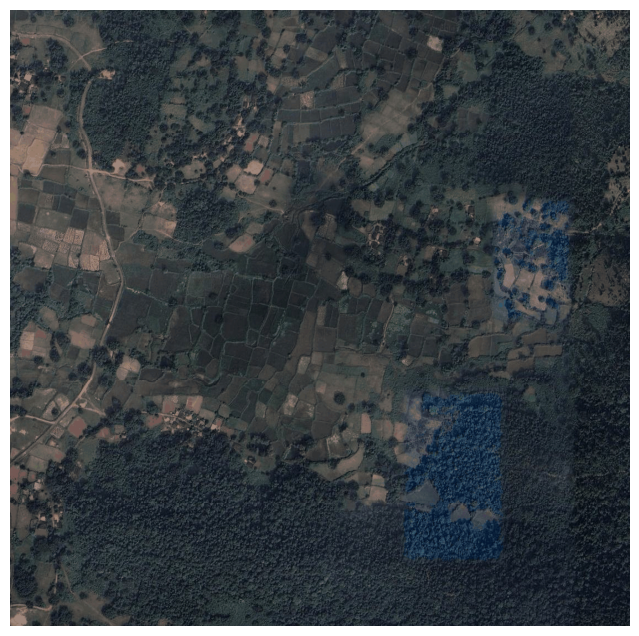

In [12]:
fig, ax = plt.subplots(5, 5, figsize=(8, 8))
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(ds.isel(lat_lag=i, lon_lag=j)['data'])
        ax[i, j].axis('off')

/tmp/ipykernel_4153494/2445725585.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = west_bengal_gdf.centroid.to_crs("EPSG:4326").iloc[0]


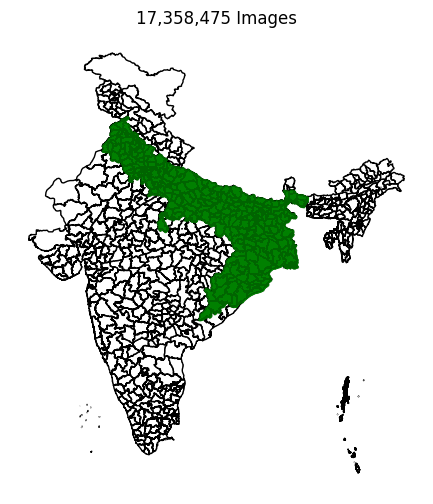

In [17]:
# plot gdf with white background
west_bengal_gdf.plot(color="white", edgecolor="black", figsize=(6, 6))
x = [p.x for p in lat_lons]
y = [p.y for p in lat_lons]
plt.scatter(x, y, color="green", s=0.1, alpha=0.1);
# plt.title("Downloading progress (green: downloaded, white: not downloaded)")
centroid = west_bengal_gdf.centroid.to_crs("EPSG:4326").iloc[0]
plt.title(f"{format(25*len(x), ',')} Images");
# set axis off
plt.axis('off');

## Appendix

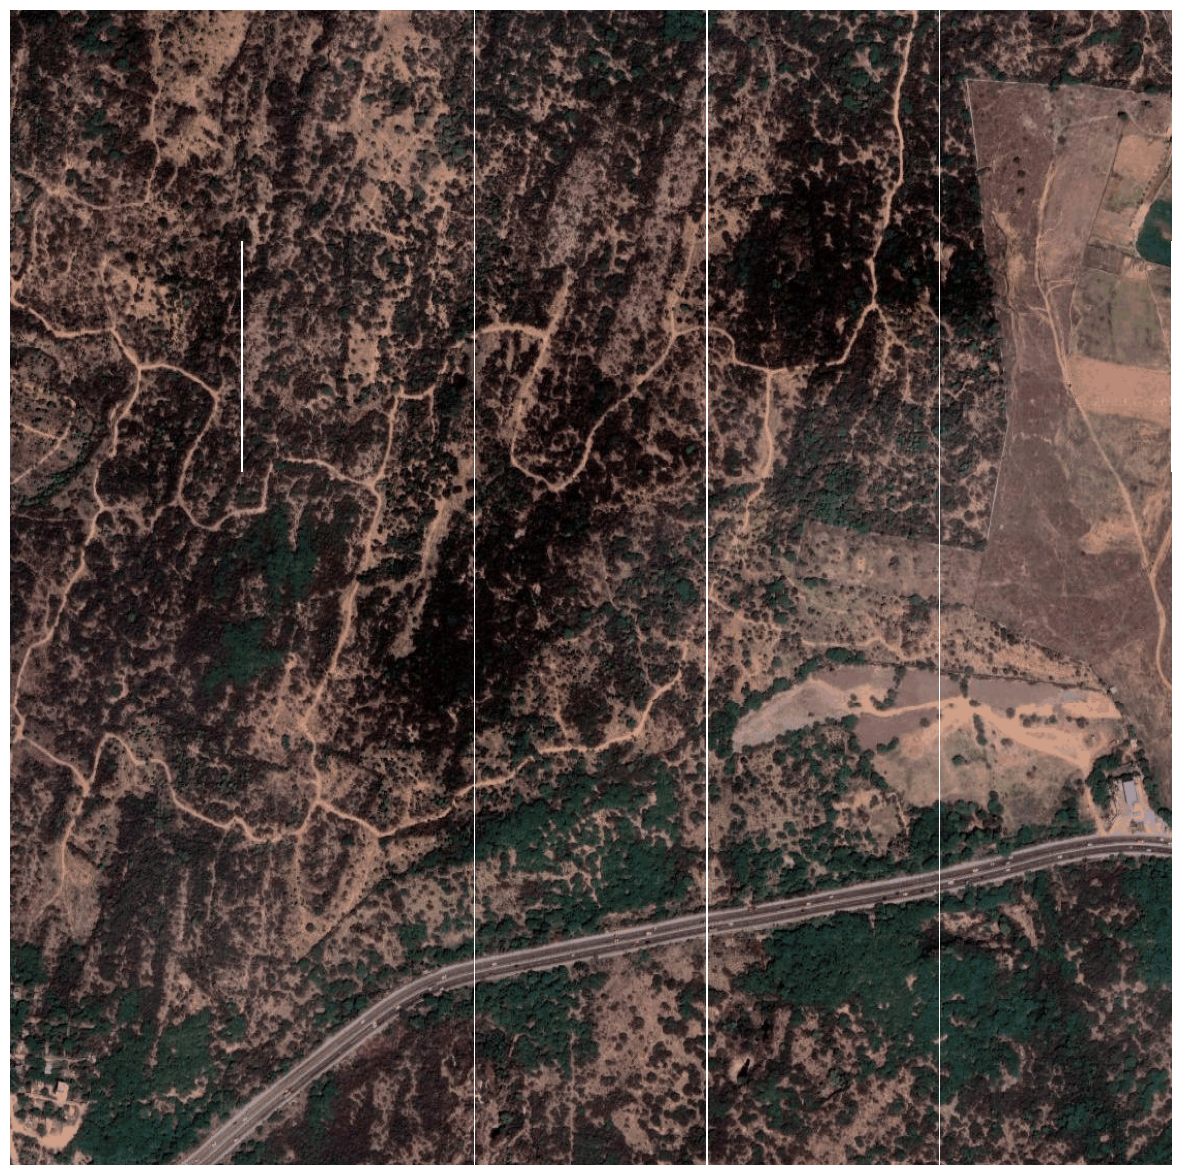

In [36]:
ds = xr.open_zarr("/home/rishabh.mondal/bkdb/statewise/delhi/28.41,77.18.zarr", consolidated=False)
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace=0, wspace=0)

for i in range(5):
    for j in range(5):
        ax[i, j].imshow(ds.isel(lat_lag=i, lon_lag=j)['data'])
        ax[i, j].axis('off')